# NASDAQ 주가 데이터 이상치 탐지하기

## 1. 데이터 소개

In [1]:
import os
import pandas as pd
import warnings
warnings.filterwarnings(action='ignore')

path = os.getenv('HOME') + '/aiffel/anomaly_detection/nasdaq/NQ=F.csv'
nd = pd.read_csv(path)
nd.head()
print(nd.shape)

(6166, 7)


In [2]:
# 날짜데이터를 Datetime 형식으로 바꿔줍니다.
nd.loc[:,'Date'] = pd.to_datetime(nd.Date)

# 데이터의 정합성을 확인합니다
nd.isna().sum()

Date            0
Open         1072
High         1072
Low          1072
Close        1072
Adj Close    1072
Volume       1072
dtype: int64

In [3]:
nd = nd.dropna(axis=0).reset_index(drop=True)
nd.isna().sum()

Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

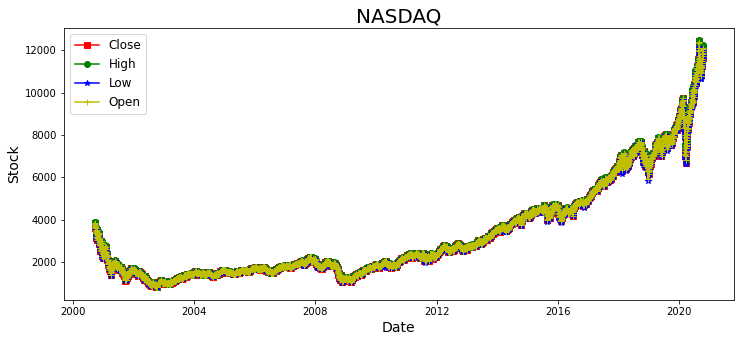

In [4]:
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams

plt.rcParams["figure.figsize"] = (12,5)
# Line Graph by matplotlib with wide-form DataFrame

plt.plot(nd.Date, nd.Close, marker='s', color='r')
plt.plot(nd.Date, nd.High, marker='o', color='g')
plt.plot(nd.Date, nd.Low, marker='*', color='b')
plt.plot(nd.Date, nd.Open, marker='+', color='y')

plt.title('NASDAQ' , fontsize=20)
plt.ylabel('Stock', fontsize=14)
plt.xlabel('Date', fontsize=14)
plt.legend(['Close', 'High', 'Low', 'Open'], fontsize=12, loc='best')

plt.show()

In [5]:
nd.loc[nd.Low > nd.High]

,Date,Open,High,Low,Close,Adj Close,Volume


### 나스닥 데이터 배경지식

나스닥에는 폭락이 3번정도로 압축할 수 있다.    
1번째 폭락은 2001년 닷컴 버블로 인한 주가 폭락이며 2번째 폭락은 2007년 서브 프라임 모기지 사태로 인한 하락, 2008년 글로벌 금융위기로 인한 폭락이다.    
마지막 폭락은 2020년 코로나19가 미국 전역에 퍼질때 나스닥 주가가 대폭락을 했다.    

최근 흐름에 대해 설명하면 현재 나스닥은 역대급이라 할 정도로 급상승을 하고 있으며 이것 또한 이상치로 분류될 가능성이 높다.

## 2. 기본통계분석으로 이상치찾기

### 1. Time-series decomposition

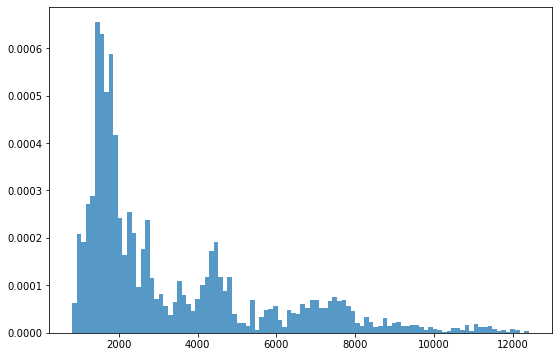

In [6]:
fig, ax = plt.subplots(figsize=(9,6))
_ = plt.hist(nd.Close, 100, density=True, alpha=0.75)

In [7]:
from statsmodels.stats.weightstats import ztest
_, p = ztest(nd.Close)
print(p)

0.0


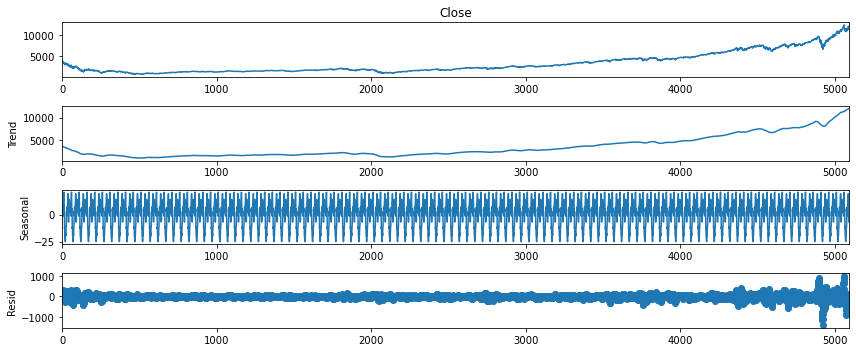

In [8]:
from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(nd.Close, model='additive', two_sided=True, 
                            period=50, extrapolate_trend='freq')
result.plot()
plt.show()

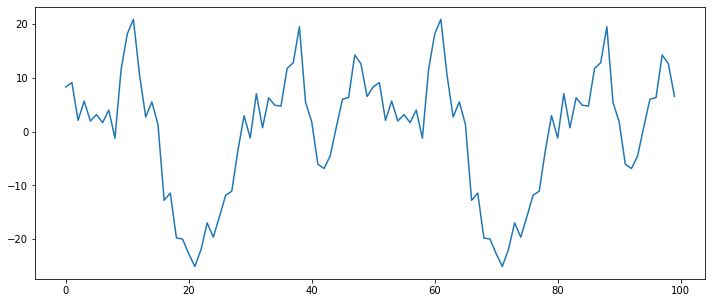

In [9]:
result.seasonal[:100].plot()

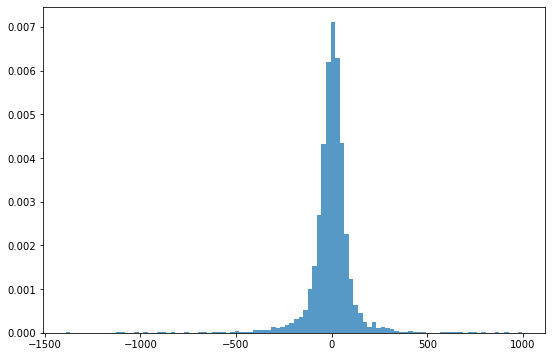

In [10]:
fig, ax = plt.subplots(figsize=(9,6))
_ = plt.hist(result.resid, 100, density=True, alpha=0.75)

In [11]:
r = result.resid.values
st, p = ztest(r)
print(st,p)

-0.8942734929026214 0.37117557875831597


### 3. 3sigma 기준 신뢰구간으로 이상치 찾기

In [12]:
# 평균과 표준편차 출력
mu, std = result.resid.mean(), result.resid.std()
print("평균:", mu, "표준편차:", std)

# 3-sigma(표준편차)를 기준으로 이상치 판단
print("이상치 갯수:", len(result.resid[(result.resid>mu+3*std)|(result.resid<mu-3*std)]))

평균: -1.3857940518773482 표준편차: 110.60068205120815
이상치 갯수: 93


In [13]:
nd.Date[result.resid[
    (result.resid>mu+3*std)|(result.resid<mu-3*std)].index]

66     2000-12-20
73     2001-01-02
91     2001-01-29
92     2001-01-30
136    2001-04-03
          ...    
5083   2020-10-05
5084   2020-10-06
5085   2020-10-07
5086   2020-10-08
5093   2020-10-19
Name: Date, Length: 93, dtype: datetime64[ns]

탐지해낸 이상치는 특이치일 가능성이 높고 최근 문제가 되고 있는 기간들을 포착했다.    
그렇기에 교정할 필요는 없다.

## 2. K-means Clustering으로 이상치 찾기

In [14]:
def my_decompose(df, features, freq=50):
    trend = pd.DataFrame()
    seasonal = pd.DataFrame()
    resid = pd.DataFrame()
    
    # 사용할 feature 마다 decompose 를 수행합니다.
    for f in features:
        result = seasonal_decompose(df[f], 
                                    model='additive', period=freq, extrapolate_trend=freq)
        trend[f] = result.trend.values
        seasonal[f] = result.seasonal.values
        resid[f] = result.resid.values
        
    return trend, seasonal, resid

# 각 변수별 트렌드/계절적/잔차
tdf, sdf, rdf = my_decompose(nd, features=['Open','High','Low','Close','Volume'])
tdf.describe()

,Open,High,Low,Close,Volume
count,5094.000000,5094.000000,5094.000000,5094.000000,5094.000000
mean,3324.303285,3355.663089,3292.204015,3326.157530,287799.789978
std,2390.871506,2412.479986,2369.858940,2394.718369,109505.235488
min,914.415000,934.695000,895.770000,915.335000,64880.520000
25%,1584.251875,1597.572500,1571.058750,1584.191100,220550.460000
50%,2263.775000,2291.211250,2231.463750,2264.287900,268829.760000
75%,4433.603750,4464.010625,4399.788125,4434.981250,319616.697500
max,12064.786259,12214.296509,11897.172140,12066.724264,776809.340000


In [15]:
rdf.describe()

,Open,High,Low,Close,Volume
count,5094.000000,5094.000000,5094.000000,5094.000000,5094.000000
mean,-1.494218,-1.447168,-1.394948,-1.402187,132.899742
std,113.106458,102.570229,117.278403,110.763008,110724.899203
min,-1280.163546,-1494.231533,-1226.595518,-1389.770659,-603014.586328
25%,-37.912202,-35.100432,-38.323649,-37.371552,-53397.033973
50%,3.575670,3.350366,4.153527,2.958782,-584.124075
75%,40.353926,37.613888,42.048756,40.813609,51481.304420
max,996.821566,933.584382,941.409836,996.232816,810690.898648


In [16]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(rdf)
print(scaler.mean_)
norm_rdf = scaler.transform(rdf)
norm_rdf

[ -1.49421837  -1.44716848  -1.39494753  -1.40218679 132.89974227]


array([[ 0.94173218,  0.84218124,  0.81160865,  0.59799575,  0.083212  ],
       [ 0.48655464,  1.27770882,  1.3787828 ,  2.08212326,  0.10453018],
       [ 1.89305329,  2.00817542,  2.03390849,  2.72037058, -0.08887086],
       ...,
       [-0.65531897, -1.82608069, -0.96473553, -1.32833825,  0.28433475],
       [-1.31334711, -1.62375976, -0.70348768, -2.17905108, -0.36419423],
       [-2.12456827, -2.48917183, -2.57191425, -3.70655626, -0.28328824]])

In [17]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=2, random_state=0).fit(norm_rdf)
print(kmeans.labels_) # 분류된 라벨은 이렇게 kemans.labels_ 로 확인합니다.

[1 1 1 ... 0 0 0]


In [18]:
import numpy as np
lbl, cnt = np.unique(kmeans.labels_,return_counts=True) 
print(lbl) # 0번 그룹, 1번 그룹으로 나뉘어졌네요
print(cnt)

[0 1]
[1025 4069]


In [19]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=15, random_state=0).fit(norm_rdf)
lbl, cnt = np.unique(kmeans.labels_,return_counts=True,)
['group:{}-count:{}'.format(group, count) for group, count in zip(lbl, cnt)]

['group:0-count:1038',
 'group:1-count:454',
 'group:2-count:32',
 'group:3-count:106',
 'group:4-count:13',
 'group:5-count:20',
 'group:6-count:74',
 'group:7-count:204',
 'group:8-count:826',
 'group:9-count:442',
 'group:10-count:34',
 'group:11-count:105',
 'group:12-count:337',
 'group:13-count:414',
 'group:14-count:995']

In [20]:
k_outlier=nd[(kmeans.labels_==2)|(kmeans.labels_==4)|(kmeans.labels_==5)|(kmeans.labels_==10)]
k_outlier.Date.unique()

array(['2001-04-04T00:00:00.000000000', '2004-01-15T00:00:00.000000000',
       '2004-01-16T00:00:00.000000000', '2007-02-27T00:00:00.000000000',
       '2007-07-26T00:00:00.000000000', '2007-10-24T00:00:00.000000000',
       '2007-11-08T00:00:00.000000000', '2017-07-27T00:00:00.000000000',
       '2017-11-09T00:00:00.000000000', '2017-11-29T00:00:00.000000000',
       '2018-02-02T00:00:00.000000000', '2018-02-09T00:00:00.000000000',
       '2018-03-01T00:00:00.000000000', '2018-10-05T00:00:00.000000000',
       '2018-12-06T00:00:00.000000000', '2018-12-07T00:00:00.000000000',
       '2018-12-21T00:00:00.000000000', '2018-12-26T00:00:00.000000000',
       '2018-12-27T00:00:00.000000000', '2019-01-03T00:00:00.000000000',
       '2019-01-04T00:00:00.000000000', '2019-03-22T00:00:00.000000000',
       '2019-05-07T00:00:00.000000000', '2019-05-09T00:00:00.000000000',
       '2019-05-10T00:00:00.000000000', '2019-05-31T00:00:00.000000000',
       '2019-06-03T00:00:00.000000000', '2019-06-04

이번에 뽑은 이상치는 기본 통계분석과 마찬가지로 전부 특이치로 보아야 하고 성능은 기본 통계분석으로 만든 이상치 탐지와 비슷하다.    

## 3. DBSCAN 알고리즘으로 이상치 찾기

In [21]:
nd.describe()

,Open,High,Low,Close,Adj Close,Volume
count,5094.000000,5094.000000,5094.000000,5094.000000,5094.000000,5.094000e+03
mean,3322.800450,3354.209317,3290.797495,3324.746141,3324.746141,2.879550e+05
std,2390.480458,2411.646052,2370.093040,2394.337534,2394.337534,1.593822e+05
min,810.000000,828.500000,797.500000,809.500000,809.500000,0.000000e+00
25%,1592.812500,1608.312500,1576.500000,1593.000000,1593.000000,1.906860e+05
50%,2229.625000,2257.375000,2210.750000,2230.250000,2230.250000,2.656720e+05
75%,4445.000000,4464.687500,4417.875000,4448.250000,4448.250000,3.558778e+05
max,12408.500000,12465.200195,12172.200195,12411.500000,12411.500000,1.580041e+06


In [22]:
pd.DataFrame(kmeans.cluster_centers_, columns=['Open','High','Low','Close','Volume'])

,Open,High,Low,Close,Volume
0,-0.227474,-0.233726,-0.196266,-0.202156,0.056737
1,0.887822,0.923669,0.957192,0.939782,-0.291426
2,-4.216525,-4.578292,-4.190891,-4.289738,0.564549
3,2.293611,2.380824,2.415479,2.376406,-0.438337
4,-8.262590,-7.541295,-8.315885,-7.407110,-1.791962
5,6.027197,6.084572,6.079186,6.001044,-0.221012
6,-1.181870,-1.306283,-1.849091,-1.821151,2.970848
7,0.423823,0.430877,0.494239,0.494629,-1.930095
8,0.313333,0.342215,0.265388,0.281084,0.463783
9,-0.898808,-0.913748,-0.865116,-0.844427,0.338528


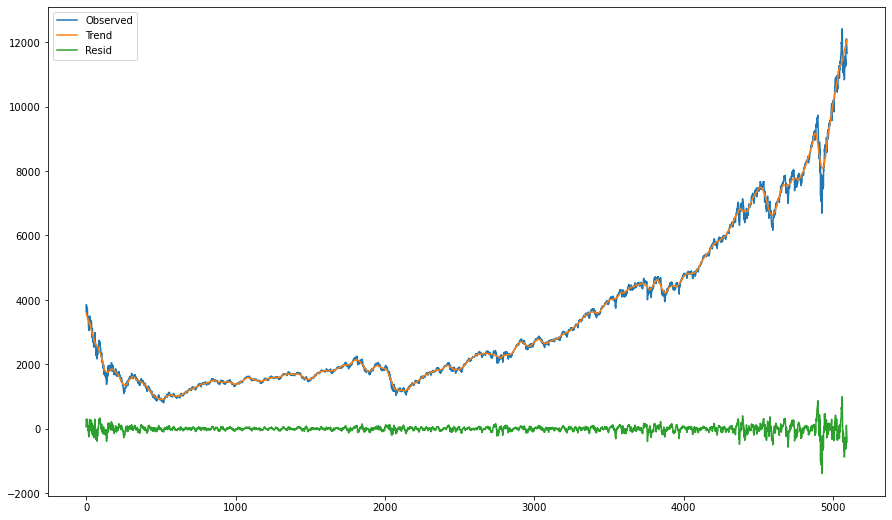

In [23]:
fig = plt.figure(figsize=(15,9))
ax = fig.add_subplot(111)
nd.Close.plot(ax=ax, label='Observed', legend=True)
tdf.Close.plot(ax=ax, label='Trend', legend=True)
rdf.Close.plot(ax=ax,label='Resid', legend=True)
plt.show()

In [24]:
from sklearn.cluster import DBSCAN
clustering = DBSCAN(eps=0.7, min_samples=2).fit(norm_rdf)
clustering

DBSCAN(eps=0.7, min_samples=2)

In [25]:
print(clustering.labels_)

[ 0  0  0 ...  0 -1 -1]


In [26]:
lbl, cnt = np.unique(clustering.labels_,return_counts=True)
['group:{}-count:{}'.format(group, count) for group, count in zip(lbl, cnt)]

['group:-1-count:196',
 'group:0-count:4839',
 'group:1-count:3',
 'group:2-count:12',
 'group:3-count:2',
 'group:4-count:2',
 'group:5-count:2',
 'group:6-count:2',
 'group:7-count:3',
 'group:8-count:2',
 'group:9-count:2',
 'group:10-count:2',
 'group:11-count:2',
 'group:12-count:2',
 'group:13-count:2',
 'group:14-count:2',
 'group:15-count:2',
 'group:16-count:2',
 'group:17-count:2',
 'group:18-count:2',
 'group:19-count:2',
 'group:20-count:2',
 'group:21-count:3',
 'group:22-count:2',
 'group:23-count:2']

특이치들이 너무 다양하게 clustering된 결과로 볼 수 있다.

## 4. LSTM 오토인코더로 이상치 찾기

In [27]:
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, RepeatVector, TimeDistributed
from tensorflow.keras.losses import Huber
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

In [28]:
tf.random.set_seed(777)
np.random.seed(777)

In [29]:
from sklearn.preprocessing import StandardScaler


window_size = 10
batch_size = 32
features = ['Open','High','Low','Close','Volume']
n_features = len(features)
TRAIN_SIZE = int(len(nd)*0.7)


scaler = StandardScaler()
scaler = scaler.fit(nd.loc[:TRAIN_SIZE,features].values)
scaled = scaler.transform(nd[features].values)

In [30]:
train_gen = TimeseriesGenerator(
    data = scaled,
    targets = scaled,
    length = window_size,
    stride=1,
    sampling_rate=1,
    batch_size= batch_size,
    shuffle=False,
    start_index=0,
    end_index=None,
)

valid_gen = TimeseriesGenerator(
    data = scaled,
    targets = scaled,
    length = window_size,
    stride=1,
    sampling_rate=1,
    batch_size=batch_size,
    shuffle=False,
    start_index=TRAIN_SIZE,
    end_index=None,
)

print(train_gen[0][0].shape)
print(train_gen[0][1].shape)

(32, 10, 5)
(32, 5)


In [31]:
model = Sequential([
    # >> 인코더 시작
    LSTM(64, activation='relu', return_sequences=True, 
         input_shape=(window_size, n_features)),
    LSTM(16, activation='relu', return_sequences=False),
    ## << 인코더 끝
    ## >> Bottleneck
    RepeatVector(window_size),
    ## << Bottleneck
    ## >> 디코더 시작
    LSTM(16, activation='relu', return_sequences=True),
    LSTM(64, activation='relu', return_sequences=False),
    Dense(n_features)
    ## << 디코더 끝
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 10, 64)            17920     
_________________________________________________________________
lstm_1 (LSTM)                (None, 16)                5184      
_________________________________________________________________
repeat_vector (RepeatVector) (None, 10, 16)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 10, 16)            2112      
_________________________________________________________________
lstm_3 (LSTM)                (None, 64)                20736     
_________________________________________________________________
dense (Dense)                (None, 5)                 325       
Total params: 46,277
Trainable params: 46,277
Non-trainable params: 0
____________________________________________________

In [32]:
import os

checkpoint_path = os.getenv('HOME')+'/aiffel/anomaly_detection/nasdaq/mymodel.ckpt'
checkpoint = ModelCheckpoint(checkpoint_path, 
                             save_weights_only=True, 
                             save_best_only=True, 
                             monitor='val_loss',
                             verbose=1)



early_stop = EarlyStopping(monitor='val_loss', patience=5)

model.compile(loss='mae', optimizer='adam',metrics=["mae"])

In [33]:
hist = model.fit(train_gen, 
          validation_data=valid_gen,
          steps_per_epoch=len(train_gen),
          validation_steps=len(valid_gen),
          epochs=50, 
          callbacks=[checkpoint, early_stop])

Epoch 1/50
159/159 [==============================] - ETA: 0s - loss: 1.4782 - mae: 1.4782
Epoch 00001: val_loss improved from inf to 1.95880, saving model to /home/aiffel0038/aiffel/anomaly_detection/nasdaq/mymodel.ckpt
159/159 [==============================] - 5s 31ms/step - loss: 1.4782 - mae: 1.4782 - val_loss: 1.9588 - val_mae: 1.9588
Epoch 2/50
159/159 [==============================] - ETA: 0s - loss: 0.6406 - mae: 0.6406
Epoch 00002: val_loss improved from 1.95880 to 0.82143, saving model to /home/aiffel0038/aiffel/anomaly_detection/nasdaq/mymodel.ckpt
159/159 [==============================] - 5s 30ms/step - loss: 0.6406 - mae: 0.6406 - val_loss: 0.8214 - val_mae: 0.8214
Epoch 3/50
159/159 [==============================] - ETA: 0s - loss: 0.4378 - mae: 0.4378
Epoch 00003: val_loss improved from 0.82143 to 0.40666, saving model to /home/aiffel0038/aiffel/anomaly_detection/nasdaq/mymodel.ckpt
159/159 [==============================] - 5s 30ms/step - loss: 0.4378 - mae: 0.4378 

In [34]:
model.load_weights(checkpoint_path)

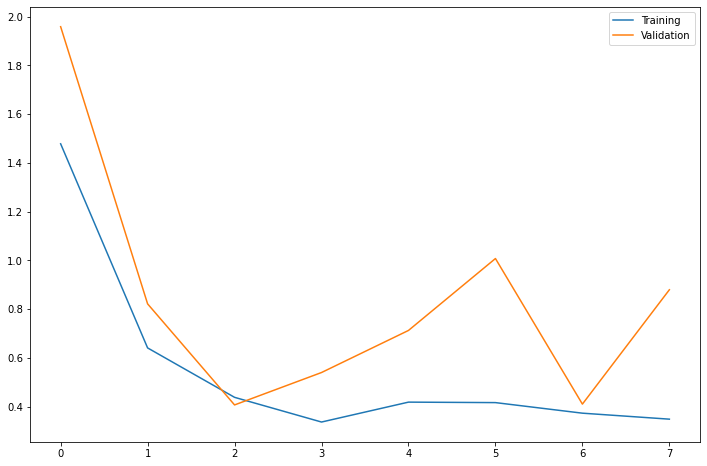

In [35]:
fig = plt.figure(figsize=(12,8))
plt.plot(hist.history['loss'], label='Training')
plt.plot(hist.history['val_loss'], label='Validation')
plt.legend()

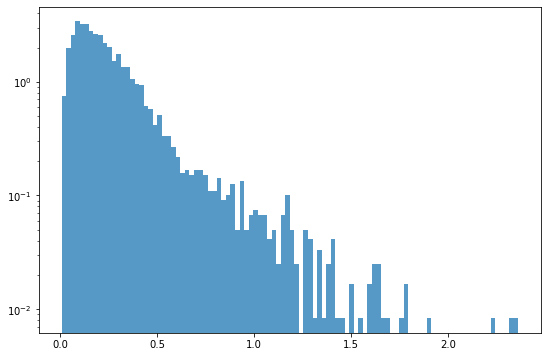

In [36]:
pred = model.predict(train_gen)
real = scaled[window_size:]

mae_loss = np.mean(np.abs(pred-real), axis=1)

# 샘플 개수가 많기 때문에 y축을 로그 스케일로 그립니다
fig, ax = plt.subplots(figsize=(9,6))
_ = plt.hist(mae_loss, 100, density=True, alpha=0.75, log=True)

In [50]:
import copy

test_nd = copy.deepcopy(nd.loc[window_size:]).reset_index(drop=True)
test_nd['Loss'] = mae_loss

threshold = 1.2
test_nd.loc[test_nd.Loss>threshold]

,Date,Open,High,Low,Close,Adj Close,Volume,Loss
1747,2007-08-16,1877.500000,1878.750000,1813.750000,1856.500000,1856.500000,982573.0,1.243003
2035,2008-10-10,1281.750000,1326.250000,1198.250000,1282.500000,1282.500000,829115.0,1.221858
3534,2014-10-15,3823.750000,3831.500000,3691.250000,3752.000000,3752.000000,831107.0,1.421855
3535,2014-10-16,3751.000000,3786.500000,3684.000000,3741.500000,3741.500000,695840.0,1.233041
3747,2015-08-24,4183.750000,4196.250000,3908.250000,4003.250000,4003.250000,746533.0,1.341565
4360,2018-02-05,6752.250000,6813.500000,6387.750000,6429.250000,6429.250000,931677.0,1.295027
4396,2018-03-28,6550.250000,6582.250000,6421.000000,6477.250000,6477.250000,948120.0,1.394121
4532,2018-10-11,7010.250000,7138.000000,6907.750000,7031.000000,7031.000000,1146270.0,1.722030
4543,2018-10-26,6882.000000,6986.500000,6734.250000,6893.250000,6893.250000,1069548.0,1.324338
4560,2018-11-20,6668.500000,6670.000000,6449.500000,6532.500000,6532.500000,910469.0,1.234766


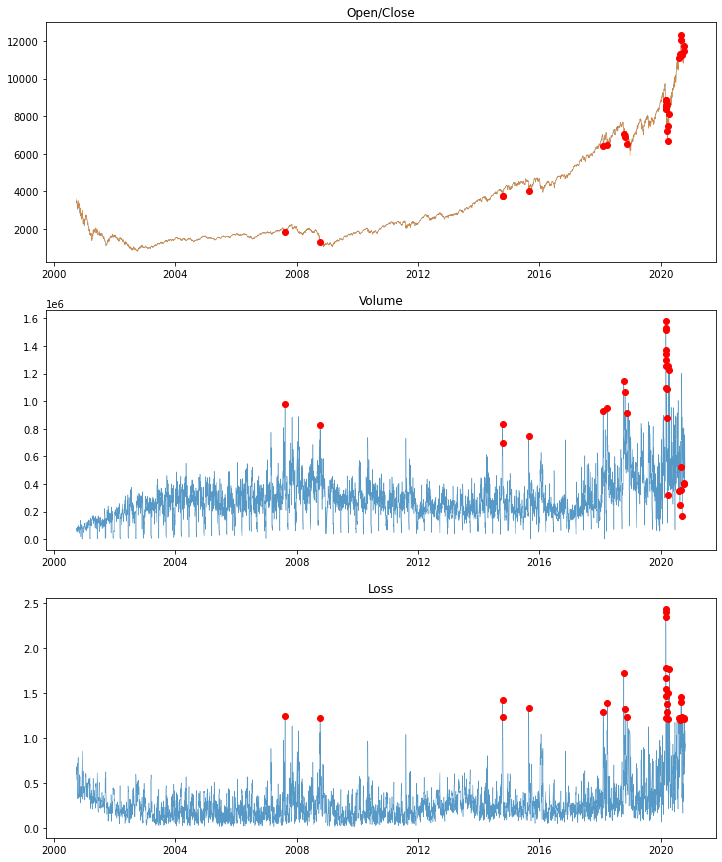

In [48]:
threshold = 1.2
fig = plt.figure(figsize=(12,15))

# 가격들 그래프입니다
ax = fig.add_subplot(311)
ax.set_title('Open/Close')
plt.plot(test_nd.Date, test_nd.Close, linewidth=0.5, alpha=0.75, label='Close')
plt.plot(test_nd.Date, test_nd.Open, linewidth=0.5, alpha=0.75, label='Open')
plt.plot(test_nd.Date, test_nd.Close, 'or', markevery=[mae_loss>threshold])

# 거래량 그래프입니다
ax = fig.add_subplot(312)
ax.set_title('Volume')
plt.plot(test_nd.Date, test_nd.Volume, linewidth=0.5, alpha=0.75, label='Volume')
plt.plot(test_nd.Date, test_nd.Volume, 'or', markevery=[mae_loss>threshold])

# 오차율 그래프입니다
ax = fig.add_subplot(313)
ax.set_title('Loss')
plt.plot(test_nd.Date, test_nd.Loss, linewidth=0.5, alpha=0.75, label='Loss')
plt.plot(test_nd.Date, test_nd.Loss, 'or', markevery=[mae_loss>threshold])

위의 통계분석과 클러스터링으로 추출할 수 있는 건 기간들로 광범위했다.    
그러나 LSTM을 이용한 분석에서는 특정점을 명확하게 보여준다.     
특히 2007년 8월 16일과 2008년 10월을 정확하게 짚어 냈으며 최근 주가 대폭락인 3월 9일,3월 12일 정확하게 짚어냈다.    
또한 최근 급성장하는 장도 정확하게 표현하고 있다.

## 4. LSTM방식에 time_distributed 추가하기

In [40]:
model = Sequential([
    # >> 인코더 시작
    LSTM(64, activation='relu', return_sequences=True, 
         input_shape=(window_size, n_features)),
    TimeDistributed(Dense(n_features)),
    LSTM(16, activation='relu', return_sequences=False),
    ## << 인코더 끝
    ## >> Bottleneck
    RepeatVector(window_size),
    ## << Bottleneck
    ## >> 디코더 시작
    LSTM(16, activation='relu', return_sequences=True),
    TimeDistributed(Dense(n_features)),
    LSTM(64, activation='relu', return_sequences=False),
    Dense(n_features)
    ## << 디코더 끝
])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, 10, 64)            17920     
_________________________________________________________________
time_distributed (TimeDistri (None, 10, 5)             325       
_________________________________________________________________
lstm_5 (LSTM)                (None, 16)                1408      
_________________________________________________________________
repeat_vector_1 (RepeatVecto (None, 10, 16)            0         
_________________________________________________________________
lstm_6 (LSTM)                (None, 10, 16)            2112      
_________________________________________________________________
time_distributed_1 (TimeDist (None, 10, 5)             85        
_________________________________________________________________
lstm_7 (LSTM)                (None, 64)               

In [41]:
import os

checkpoint_path = os.getenv('HOME')+'/aiffel/anomaly_detection/nasdaq/mymodel2.ckpt'
checkpoint = ModelCheckpoint(checkpoint_path, 
                             save_weights_only=True, 
                             save_best_only=True, 
                             monitor='val_loss',
                             verbose=1)



early_stop = EarlyStopping(monitor='val_loss', patience=5)

model.compile(loss='mae', optimizer='adam',metrics=["mae"])

In [42]:
model.compile(optimizer='adam', loss='mse')
hist = model.fit(train_gen, 
          validation_data=valid_gen,
          steps_per_epoch=len(train_gen),
          validation_steps=len(valid_gen),
          epochs=50, 
          callbacks=[checkpoint, early_stop])

Epoch 1/50
159/159 [==============================] - ETA: 0s - loss: 5.7020
Epoch 00001: val_loss improved from inf to 2.28190, saving model to /home/aiffel0038/aiffel/anomaly_detection/nasdaq/mymodel2.ckpt
159/159 [==============================] - 5s 32ms/step - loss: 5.7020 - val_loss: 2.2819
Epoch 2/50
159/159 [==============================] - ETA: 0s - loss: 1.1090
Epoch 00002: val_loss improved from 2.28190 to 0.57271, saving model to /home/aiffel0038/aiffel/anomaly_detection/nasdaq/mymodel2.ckpt
159/159 [==============================] - 5s 30ms/step - loss: 1.1090 - val_loss: 0.5727
Epoch 3/50
159/159 [==============================] - ETA: 0s - loss: 0.3282
Epoch 00003: val_loss improved from 0.57271 to 0.47254, saving model to /home/aiffel0038/aiffel/anomaly_detection/nasdaq/mymodel2.ckpt
159/159 [==============================] - 5s 29ms/step - loss: 0.3282 - val_loss: 0.4725
Epoch 4/50
159/159 [==============================] - ETA: 0s - loss: 0.3041
Epoch 00004: val_loss

In [43]:
model.load_weights(checkpoint_path)

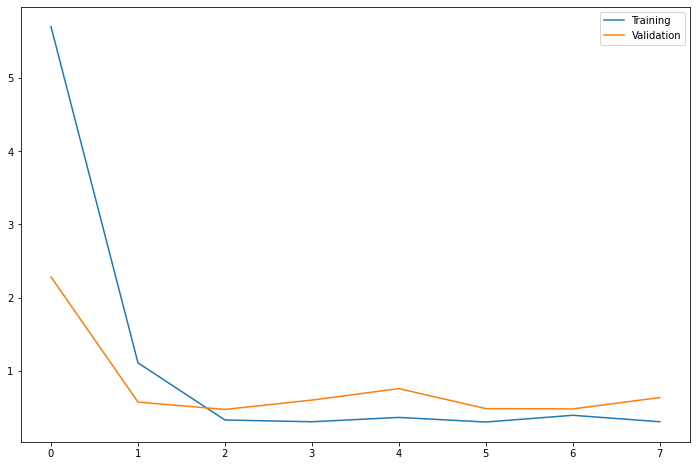

In [44]:
fig = plt.figure(figsize=(12,8))
plt.plot(hist.history['loss'], label='Training')
plt.plot(hist.history['val_loss'], label='Validation')
plt.legend()

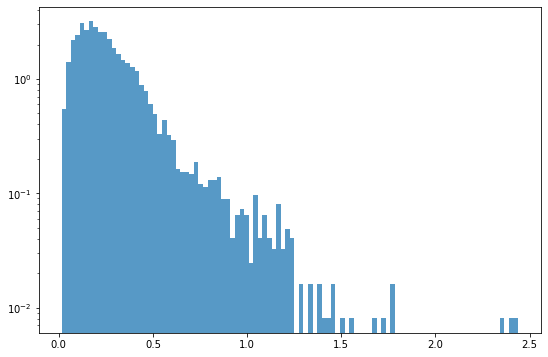

In [45]:
pred = model.predict(train_gen)
real = scaled[window_size:]

mae_loss = np.mean(np.abs(pred-real), axis=1)

# 샘플 개수가 많기 때문에 y축을 로그 스케일로 그립니다
fig, ax = plt.subplots(figsize=(9,6))
_ = plt.hist(mae_loss, 100, density=True, alpha=0.75, log=True)

In [51]:
import copy

test_nd = copy.deepcopy(nd.loc[window_size:]).reset_index(drop=True)
test_nd['Loss'] = mae_loss

threshold = 1.2
test_nd.loc[test_nd.Loss>threshold]

,Date,Open,High,Low,Close,Adj Close,Volume,Loss
1747,2007-08-16,1877.500000,1878.750000,1813.750000,1856.500000,1856.500000,982573.0,1.243003
2035,2008-10-10,1281.750000,1326.250000,1198.250000,1282.500000,1282.500000,829115.0,1.221858
3534,2014-10-15,3823.750000,3831.500000,3691.250000,3752.000000,3752.000000,831107.0,1.421855
3535,2014-10-16,3751.000000,3786.500000,3684.000000,3741.500000,3741.500000,695840.0,1.233041
3747,2015-08-24,4183.750000,4196.250000,3908.250000,4003.250000,4003.250000,746533.0,1.341565
4360,2018-02-05,6752.250000,6813.500000,6387.750000,6429.250000,6429.250000,931677.0,1.295027
4396,2018-03-28,6550.250000,6582.250000,6421.000000,6477.250000,6477.250000,948120.0,1.394121
4532,2018-10-11,7010.250000,7138.000000,6907.750000,7031.000000,7031.000000,1146270.0,1.722030
4543,2018-10-26,6882.000000,6986.500000,6734.250000,6893.250000,6893.250000,1069548.0,1.324338
4560,2018-11-20,6668.500000,6670.000000,6449.500000,6532.500000,6532.500000,910469.0,1.234766


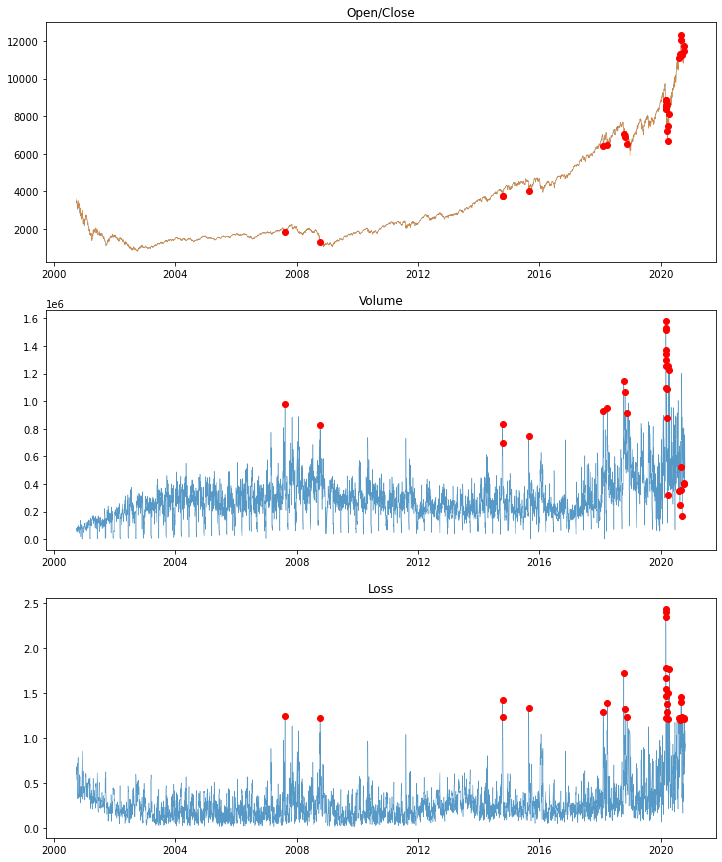

In [49]:
threshold = 1.2
fig = plt.figure(figsize=(12,15))

# 가격들 그래프입니다
ax = fig.add_subplot(311)
ax.set_title('Open/Close')
plt.plot(test_nd.Date, test_nd.Close, linewidth=0.5, alpha=0.75, label='Close')
plt.plot(test_nd.Date, test_nd.Open, linewidth=0.5, alpha=0.75, label='Open')
plt.plot(test_nd.Date, test_nd.Close, 'or', markevery=[mae_loss>threshold])

# 거래량 그래프입니다
ax = fig.add_subplot(312)
ax.set_title('Volume')
plt.plot(test_nd.Date, test_nd.Volume, linewidth=0.5, alpha=0.75, label='Volume')
plt.plot(test_nd.Date, test_nd.Volume, 'or', markevery=[mae_loss>threshold])

# 오차율 그래프입니다
ax = fig.add_subplot(313)
ax.set_title('Loss')
plt.plot(test_nd.Date, test_nd.Loss, linewidth=0.5, alpha=0.75, label='Loss')
plt.plot(test_nd.Date, test_nd.Loss, 'or', markevery=[mae_loss>threshold])

결과론적으로 성능은 추가한것과 차이가 없다.     
그러나 validation loss 그래프같은 경우 첫번쨰 모델은 random에 가깝게 보이지만 개선된 모델에서는 안정적으로 줄어들었다.